In [4]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline

In [5]:
cv2.__version__

'3.4.2'

In [5]:
def display(img,cmap='gray'):
    fig = plt.figure(figsize=(12,10))
    ax = fig.add_subplot(111)
    ax.imshow(img,cmap='gray')

# FLANN based Matcher

In [75]:
# Initiate SIFT detector

def check(needCheck, real, ratio = 0.7, display=True):
    sift = cv2.xfeatures2d.SIFT_create()

    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(real,None)
    kp2, des2 = sift.detectAndCompute(needCheck,None)

    # FLANN parameters
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)  

    flann = cv2.FlannBasedMatcher(index_params,search_params)

    matches = flann.knnMatch(des1,des2,k=2)

    good = []

    # ratio test
    for i,(match1,match2) in enumerate(matches):
        if match1.distance < ratio *match2.distance:
            good.append([match1])


    flann_matches = cv2.drawMatchesKnn(real,kp1,needCheck,kp2,good,None,flags=0)
    goodLength = len(good)
    if(display == True):
        print('kp1 Length:',len(kp1))
        print('kp2 Length:',len(kp2))
        print('good Length:',goodLength)
     
    return goodLength , flann_matches

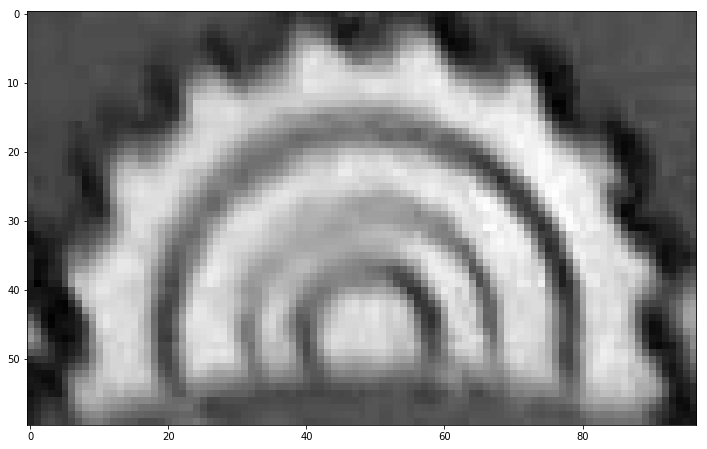

In [180]:
real = cv2.imread('../data/real-features/1.jpg', 0)
display(real)

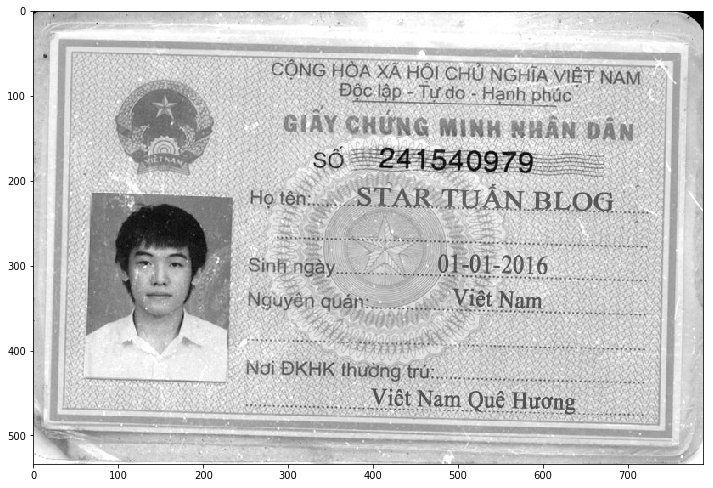

In [181]:
# needCheck = cv2.imread('../data/real-id-cards/1.jpg', 0)
# needCheck = cv2.imread('../data/real-id-cards/3.jpg', 0)

needCheck = cv2.imread('../data/fake-id-cards/0.jpg', 0)

#needCheck = cv2.imread('../data/other-cards/2.jpg', 0)
display(needCheck)

# Test without Egde detection

kp1 Length: 37
kp2 Length: 5913
good Length: 0
goodLength 0


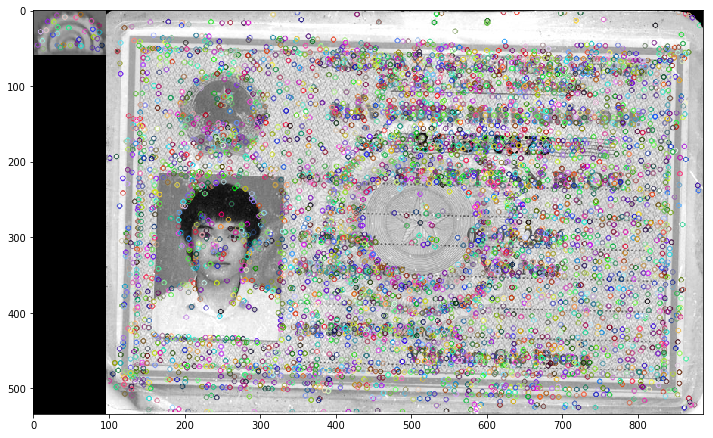

In [182]:
goodLength , flann_matches = check(needCheck, real, ratio = 0.45, display=True)
print('goodLength' , goodLength)
display(flann_matches)

# Test with Edge detection

## Choosing Thresholds

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [255,   0,   0, ...,   0,   0,   0],
       [255, 255,   0, ...,   0,   0,   0],
       [  0, 255,   0, ...,   0,   0,   0]], dtype=uint8)

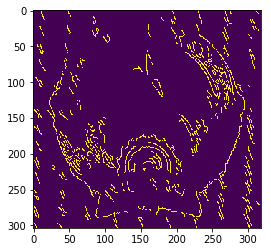

In [50]:
def edgeDetection(img , display = False):
    # Calculate the median pixel value
    med_val = np.median(img)
    # Lower bound is either 0 or 70% of the median value, whicever is higher
    lower = int(max(0, 0.7* med_val))
    # Upper bound is either 255 or 30% above the median value, whichever is lower
    upper = int(min(255,1.3 * med_val))
    edges = cv2.Canny(image=img, threshold1=lower , threshold2=upper)
    if(display):
        plt.imshow(edges)
    return edges

edgeDetection(real, display = True)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

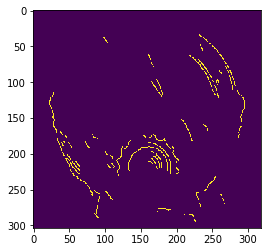

In [67]:
def edgeDetectionWithBlur(img , display = False):
    # Calculate the median pixel value
    med_val = np.median(img)
    # Lower bound is either 0 or 70% of the median value, whicever is higher
    lower = int(max(0, 0.7* med_val))
    # Upper bound is either 255 or 30% above the median value, whichever is lower
    upper = int(min(255,1.3 * med_val))
    edges = cv2.Canny(image=img, threshold1=lower , threshold2=upper)
    # blur image
    blurred_img = cv2.blur(img,ksize=(3,3))
    edges = cv2.Canny(image=blurred_img, threshold1=lower , threshold2=upper)
    if(display):
         plt.imshow(edges)
    return edges
edgeDetectionWithBlur(real, display = True)

kp1 Length: 333
goodLength: 42
kp1 Length: 63
goodLength: 7


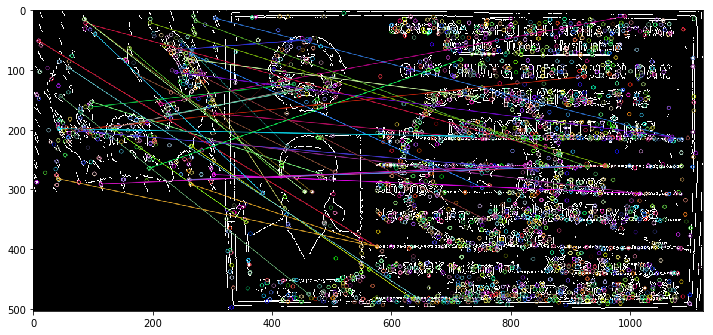

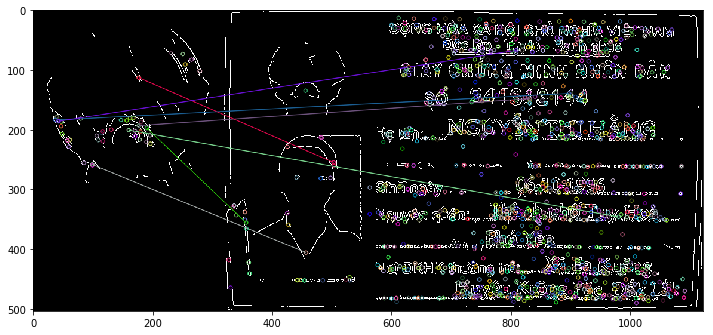

In [122]:
goodLength , flann_matches = check(edgeDetection(needCheck), edgeDetection(real), ratio = 0.9, display=True)
display(flann_matches)
goodLength , flann_matches = check(edgeDetectionWithBlur(needCheck), edgeDetectionWithBlur(real), ratio = 0.9, display=True)
display(flann_matches)

# Report

In [166]:
realFeatureNumber = 29
realIdCardNumber = 3
otherCardNumber = 4
fakeIdCardNumber = 4
# ratioes = [0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75]
ratioes = [0.3, 0.35, 0.4]

rows = []

for i in np.arange(realFeatureNumber):
    real = cv2.imread('../data/real-features/{}.jpg'.format(i), 0)
    for ratio in ratioes:
        # for real id cards
        for j in np.arange(realIdCardNumber):
            print('i' , i,'j' , j, 'ratio', ratio)
            try:
                needCheck = cv2.imread('../data/real-id-cards/{}.jpg'.format(j), 0)
                goodLength , flann_matches  = check(needCheck, real, ratio, False)
                rows.append([i, j, 'R', goodLength , ratio ])
            except Exception as e:
                print('Can not load file at {},{}'.format(i,j))
        # for other cards
        for k in np.arange(otherCardNumber):
            print('i', i, 'k' , k, 'ratio', ratio )
            try:
                needCheck = cv2.imread('../data/other-cards/{}.jpg'.format(k), 0)
                goodLength , flann_matches = check(needCheck, real, ratio, False)
                rows.append([i, k, 'O', goodLength , ratio ])
            except Exception as e:
                print('Can not load file at {},{}'.format(i,k))
        
        # for fake id cards
        for f in np.arange(fakeIdCardNumber):
            print('i', i, 'f' , f, 'ratio', ratio )
            try:
                needCheck = cv2.imread('../data/fake-id-cards/{}.jpg'.format(f), 0)
                goodLength , flann_matches = check(needCheck, real, ratio, False)
                rows.append([i, f, 'F', goodLength , ratio ])
            except Exception as e:
                print('Can not load file at {},{}'.format(i,f))
            
data = pd.DataFrame(rows, columns=['feature' , 'image' , 'type' , 'good', 'ratio'])
data
# export to csv
filePath = './report-{}.csv'.format(datetime.now()).replace(' ','-')
print('Export successfully:' ,filePath)
data.to_csv(filePath, index=False)

i 0 j 0 ratio 0.3
i 0 j 1 ratio 0.3
i 0 j 2 ratio 0.3
i 0 k 0 ratio 0.3
i 0 k 1 ratio 0.3
i 0 k 2 ratio 0.3
i 0 k 3 ratio 0.3
i 0 f 0 ratio 0.3
i 0 f 1 ratio 0.3
i 0 f 2 ratio 0.3
i 0 f 3 ratio 0.3
i 0 j 0 ratio 0.35
i 0 j 1 ratio 0.35
i 0 j 2 ratio 0.35
i 0 k 0 ratio 0.35
i 0 k 1 ratio 0.35
i 0 k 2 ratio 0.35
i 0 k 3 ratio 0.35
i 0 f 0 ratio 0.35
i 0 f 1 ratio 0.35
i 0 f 2 ratio 0.35
i 0 f 3 ratio 0.35
i 0 j 0 ratio 0.4
i 0 j 1 ratio 0.4
i 0 j 2 ratio 0.4
i 0 k 0 ratio 0.4
i 0 k 1 ratio 0.4
i 0 k 2 ratio 0.4
i 0 k 3 ratio 0.4
i 0 f 0 ratio 0.4
i 0 f 1 ratio 0.4
i 0 f 2 ratio 0.4
i 0 f 3 ratio 0.4
i 1 j 0 ratio 0.3
i 1 j 1 ratio 0.3
i 1 j 2 ratio 0.3
i 1 k 0 ratio 0.3
i 1 k 1 ratio 0.3
i 1 k 2 ratio 0.3
i 1 k 3 ratio 0.3
i 1 f 0 ratio 0.3
i 1 f 1 ratio 0.3
i 1 f 2 ratio 0.3
i 1 f 3 ratio 0.3
i 1 j 0 ratio 0.35
i 1 j 1 ratio 0.35
i 1 j 2 ratio 0.35
i 1 k 0 ratio 0.35
i 1 k 1 ratio 0.35
i 1 k 2 ratio 0.35
i 1 k 3 ratio 0.35
i 1 f 0 ratio 0.35
i 1 f 1 ratio 0.35
i 1 f 2 ratio 0.35
i 1 f 3

i 13 j 1 ratio 0.35
i 13 j 2 ratio 0.35
i 13 k 0 ratio 0.35
i 13 k 1 ratio 0.35
i 13 k 2 ratio 0.35
i 13 k 3 ratio 0.35
i 13 f 0 ratio 0.35
i 13 f 1 ratio 0.35
i 13 f 2 ratio 0.35
i 13 f 3 ratio 0.35
i 13 j 0 ratio 0.4
i 13 j 1 ratio 0.4
i 13 j 2 ratio 0.4
i 13 k 0 ratio 0.4
i 13 k 1 ratio 0.4
i 13 k 2 ratio 0.4
i 13 k 3 ratio 0.4
i 13 f 0 ratio 0.4
i 13 f 1 ratio 0.4
i 13 f 2 ratio 0.4
i 13 f 3 ratio 0.4
i 14 j 0 ratio 0.3
i 14 j 1 ratio 0.3
i 14 j 2 ratio 0.3
i 14 k 0 ratio 0.3
i 14 k 1 ratio 0.3
i 14 k 2 ratio 0.3
i 14 k 3 ratio 0.3
i 14 f 0 ratio 0.3
i 14 f 1 ratio 0.3
i 14 f 2 ratio 0.3
i 14 f 3 ratio 0.3
i 14 j 0 ratio 0.35
i 14 j 1 ratio 0.35
i 14 j 2 ratio 0.35
i 14 k 0 ratio 0.35
i 14 k 1 ratio 0.35
i 14 k 2 ratio 0.35
i 14 k 3 ratio 0.35
i 14 f 0 ratio 0.35
i 14 f 1 ratio 0.35
i 14 f 2 ratio 0.35
i 14 f 3 ratio 0.35
i 14 j 0 ratio 0.4
i 14 j 1 ratio 0.4
i 14 j 2 ratio 0.4
i 14 k 0 ratio 0.4
i 14 k 1 ratio 0.4
i 14 k 2 ratio 0.4
i 14 k 3 ratio 0.4
i 14 f 0 ratio 0.4
i 14 f 1 r

i 26 f 1 ratio 0.3
i 26 f 2 ratio 0.3
i 26 f 3 ratio 0.3
i 26 j 0 ratio 0.35
i 26 j 1 ratio 0.35
i 26 j 2 ratio 0.35
i 26 k 0 ratio 0.35
i 26 k 1 ratio 0.35
i 26 k 2 ratio 0.35
i 26 k 3 ratio 0.35
i 26 f 0 ratio 0.35
i 26 f 1 ratio 0.35
i 26 f 2 ratio 0.35
i 26 f 3 ratio 0.35
i 26 j 0 ratio 0.4
i 26 j 1 ratio 0.4
i 26 j 2 ratio 0.4
i 26 k 0 ratio 0.4
i 26 k 1 ratio 0.4
i 26 k 2 ratio 0.4
i 26 k 3 ratio 0.4
i 26 f 0 ratio 0.4
i 26 f 1 ratio 0.4
i 26 f 2 ratio 0.4
i 26 f 3 ratio 0.4
i 27 j 0 ratio 0.3
i 27 j 1 ratio 0.3
i 27 j 2 ratio 0.3
i 27 k 0 ratio 0.3
i 27 k 1 ratio 0.3
i 27 k 2 ratio 0.3
i 27 k 3 ratio 0.3
i 27 f 0 ratio 0.3
i 27 f 1 ratio 0.3
i 27 f 2 ratio 0.3
i 27 f 3 ratio 0.3
i 27 j 0 ratio 0.35
i 27 j 1 ratio 0.35
i 27 j 2 ratio 0.35
i 27 k 0 ratio 0.35
i 27 k 1 ratio 0.35
i 27 k 2 ratio 0.35
i 27 k 3 ratio 0.35
i 27 f 0 ratio 0.35
i 27 f 1 ratio 0.35
i 27 f 2 ratio 0.35
i 27 f 3 ratio 0.35
i 27 j 0 ratio 0.4
i 27 j 1 ratio 0.4
i 27 j 2 ratio 0.4
i 27 k 0 ratio 0.4
i 27 k 1 

# Analyst

In [13]:
df = pd.read_csv('./report-2019-09-29-15_44_53.021430.csv')

In [14]:
df.head()

,feature,image,type,good,ratio
0,0,0,R,0,0.3
1,0,1,R,0,0.3
2,0,2,R,0,0.3
3,0,0,O,0,0.3
4,0,1,O,0,0.3


In [19]:
df[(df['type'] == 'O') & (df['good'] == 0) ].groupby('feature').median()

,image,good,ratio
feature,,,
0,1.5,0.0,0.525
1,1.5,0.0,0.525
2,1.5,0.0,0.525
3,1.0,0.0,0.500
4,1.5,0.0,0.475
5,1.0,0.0,0.500
6,2.0,0.0,0.500
7,1.0,0.0,0.500
8,2.0,0.0,0.450


In [125]:
# check ratio for passed real id cards

In [159]:
def realIdCardPercent(ratio):
    realFeaturePassed = df[ (df['ratio'] == ratio)  & ( ((df['type'] == 'R') &  (df['good'] > 0))    ) ]
    percent = realFeaturePassed.shape[0] /  (realFeatureNumber * realIdCardNumber)
    return percent


0.6666666666666666


In [160]:
# check ratio for passed other cards
def otherCardPercent(ratio):
    otherCardPassed = df[ (df['ratio'] == ratio)  & ( ((df['type'] == 'O') &  (df['good'] == 0))    ) ]
    return (otherCardPassed.shape[0] /  (realFeatureNumber * otherCardNumber) )

In [161]:
# check ratio for fake id cards

def fakeIdCardPercent(ratio):
    fakeIdCardPassed = df[ (df['ratio'] == ratio)  & ( ((df['type'] == 'F') &  (df['good'] == 0))    ) ]
    return(fakeIdCardPassed.shape[0] /  (realFeatureNumber * fakeIdCardNumber) )

In [170]:
goodRatios = [0.3, 0.35 , 0.4, 0.45, 0.5, 0.55, 0.6]
for ratio in goodRatios:
    print('ratio', ratio)
    print('realIdCardPercent' , realIdCardPercent(ratio))
    print('otherCardPercent' , otherCardPercent(ratio))
    print('fakeIdCardPercent' , fakeIdCardPercent(ratio))

ratio 0.3
realIdCardPercent 0.16091954022988506
otherCardPercent 0.9913793103448276
fakeIdCardPercent 0.9741379310344828
ratio 0.35
realIdCardPercent 0.27586206896551724
otherCardPercent 0.9913793103448276
fakeIdCardPercent 0.9655172413793104
ratio 0.4
realIdCardPercent 0.3563218390804598
otherCardPercent 0.9913793103448276
fakeIdCardPercent 0.8879310344827587
ratio 0.45
realIdCardPercent 0.4367816091954023
otherCardPercent 0.9913793103448276
fakeIdCardPercent 0.7586206896551724
ratio 0.5
realIdCardPercent 0.5517241379310345
otherCardPercent 0.9913793103448276
fakeIdCardPercent 0.6810344827586207
ratio 0.55
realIdCardPercent 0.6666666666666666
otherCardPercent 0.9913793103448276
fakeIdCardPercent 0.49137931034482757
ratio 0.6
realIdCardPercent 0.7701149425287356
otherCardPercent 0.9913793103448276
fakeIdCardPercent 0.4396551724137931


# Check Fake

In [222]:
fakeCheckingRealFeaturePaths = [
   0,1,2,3,4,5,6,7,8,9,10,11,12
]

fakeIdPaths = [
   0,1,2,3
]

realIdPaths = [
   0,1,2,3
]

fakeCheckingRatios = [0.3, 0.35, 0.4, 0.45 , 0.5]

In [247]:
series = []
for featurePath in fakeCheckingRealFeaturePaths:
    realFeature = cv2.imread('../data/small-real-features/{}.jpg'.format(featurePath), 0)
     
    for needCheckPath in fakeIdPaths:
        fakeImage = cv2.imread('../data/fake-id-cards/{}.jpg'.format(needCheckPath), 0)  
        realImage = cv2.imread('../data/real-id-cards/{}.jpg'.format(needCheckPath), 0)
        ratio = 0.3
        print('---------')
        while(True):
           
            goodLength, flann_matches  = check(fakeImage, realFeature, ratio, False)
            fakeGoodPoints = goodLength
            
            goodLength , flann_matches  = check(realImage, realFeature, ratio, False)
            realGoodPoints = goodLength
            
            print(featurePath, needCheckPath , fakeGoodPoints,  realGoodPoints ,  ratio )
            if(ratio >= 1 or fakeGoodPoints > 0):
                series.append([featurePath, needCheckPath, needCheckPath, fakeGoodPoints, realGoodPoints , ratio , 'FAIL' ])
                print('FAIL')
                break
               
            elif(  realGoodPoints ==0 ):
                ratio = round (ratio + 0.05 , 2)
            else:
                series.append([featurePath, needCheckPath, needCheckPath, fakeGoodPoints, realGoodPoints , ratio, 'PASS' ])
                ratio = 0.3
                print('PASS')
                break
                     
            
report = pd.DataFrame(series, columns=['feature' , 'fakeID' , 'realID' , 'fakeGoodPoints' , 'realGoodPoints', 'ratio' , 'result'])  

---------
0 0 0 0 0.3
0 0 0 0 0.35
0 0 0 0 0.4
0 0 0 0 0.45
0 0 0 0 0.5
0 0 0 0 0.55
0 0 1 0 0.6
FAIL
---------
0 1 0 0 0.3
0 1 0 0 0.35
0 1 0 1 0.4
PASS
---------
0 2 0 0 0.3
0 2 0 0 0.35
0 2 0 0 0.4
0 2 0 0 0.45
0 2 0 0 0.5
0 2 0 0 0.55
0 2 0 1 0.6
PASS
---------
0 3 0 0 0.3
0 3 0 0 0.35
0 3 0 0 0.4
0 3 0 0 0.45
0 3 0 0 0.5
0 3 0 0 0.55
0 3 0 0 0.6
0 3 0 1 0.65
PASS
---------
1 0 0 0 0.3
1 0 0 0 0.35
1 0 0 0 0.4
1 0 0 0 0.45
1 0 0 0 0.5
1 0 1 0 0.55
FAIL
---------
1 1 0 0 0.3
1 1 0 0 0.35
1 1 0 0 0.4
1 1 0 0 0.45
1 1 0 0 0.5
1 1 0 1 0.55
PASS
---------
1 2 0 0 0.3
1 2 0 0 0.35
1 2 0 0 0.4
1 2 0 2 0.45
PASS
---------
1 3 0 0 0.3
1 3 0 0 0.35
1 3 0 2 0.4
PASS
---------
2 0 0 0 0.3
2 0 0 0 0.35
2 0 0 0 0.4
2 0 0 0 0.45
2 0 0 0 0.5
2 0 0 0 0.55
2 0 0 0 0.6
2 0 0 0 0.65
2 0 0 0 0.7
2 0 0 0 0.75
2 0 0 0 0.8
2 0 1 0 0.85
FAIL
---------
2 1 0 0 0.3
2 1 0 0 0.35
2 1 0 0 0.4
2 1 0 0 0.45
2 1 0 0 0.5
2 1 0 0 0.55
2 1 0 0 0.6
2 1 0 0 0.65
2 1 0 1 0.7
PASS
---------
2 2 0 0 0.3
2 2 0 0 0.35
2 2 0

In [6]:
report = pd.read_csv('./fake-detection-2019-09-30-09:48:44.643338.csv')

In [11]:
report[report['result'] == 'PASS'].groupby('feature').median()

,fakeID,realID,fakeGoodPoints,realGoodPoints,ratio
feature,,,,,
0,2.0,2.0,0.0,1.0,0.600
1,2.0,2.0,0.0,2.0,0.450
2,1.0,1.0,0.0,1.0,0.700
3,1.0,1.0,0.0,1.0,0.550
4,2.0,2.0,0.0,2.0,0.600
5,1.5,1.5,0.0,1.0,0.600
6,1.5,1.5,0.0,2.0,0.625
7,2.0,2.0,0.0,1.0,0.600
8,0.5,0.5,0.0,1.5,0.550


In [249]:
# export to csv
filePath = './fake-detection-{}.csv'.format(datetime.now()).replace(' ','-')
report.to_csv(filePath, index=False)
print('Export successfully:' ,filePath)

Export successfully: ./fake-detection-2019-09-30-09:48:44.643338.csv
